# Predicting NBA game result using sagemaker

this notebook walks through data preprocessing, modeling using Sagemaker built-in, model evaluation, and create endpoints capable of NBA game prediction

<br>The dataset that we use in this project comes from https://stats.nba.com/ which has sufficient statistic from 1996-2020. The dataset can be found in my S3 bucket: nba-public-data. FileName and description of the data as following: 

1. NBA team average statistic from 2018-2019 
2. NBA team average statistic from 2019-2020
3. NBA team box score
4. NBA team abbreviation


In [ ]:
#import packages
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from itertools import permutations
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

# load data

In [90]:
# download data from s3
data_bucket = 'nba-public-data'
model_bucket = 'nba-model'

s3 = boto3.resource('s3')

databucketref = s3.Bucket(data_bucket)
databucketref.download_file('2016-17_teamBoxScore.csv', '2016-17_teamBoxScore.csv')
databucketref.download_file('2017-18_teamBoxScore.csv', '2017-18_teamBoxScore.csv')

In [91]:
advanced_18_df = pd.read_csv('2018-19 team_advanced.csv')
advanced_19_df = pd.read_csv('2019-20 team_advanced.csv',index_col=0)
game_18_df = pd.read_csv('2018-2019 BoxScore.csv')
#game_19_df = pd.read_csv('Data/nba-enhanced-stats/2019-20 BoxScore.csv')
teamAbbreviation_df = pd.read_csv('nba_abbreviationvr2.csv',header=0,names = ['abbreviation','team'])

In [92]:
teamAbbreviation_df.head()

,abbreviation,team
0,ATL,Atlanta Hawks
1,BKN,Brooklyn Nets
2,BOS,Boston Celtics
3,CHA,Charlotte Hornets
4,CHI,Chicago Bulls


In [93]:
game_18_df.head()

,Team,Match Up,Oppt,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,MEM,MEM vs. GSW,GSW,04/10/2019,W,240,132,48,98,49.0,...,83.3,15,34,49,25,9,0,11,18,15
1,GSW,GSW @ MEM,MEM,04/10/2019,L,240,117,46,92,50.0,...,85.7,9,30,39,32,3,5,14,17,-15
2,ORL,ORL @ CHA,CHA,04/10/2019,W,240,122,48,88,54.5,...,75.0,9,30,39,24,5,2,6,19,8
3,CHA,CHA vs. ORL,ORL,04/10/2019,L,240,114,41,78,52.6,...,88.9,4,28,32,21,3,4,8,14,-8
4,MIN,MIN @ DEN,DEN,04/10/2019,L,240,95,39,91,42.9,...,66.7,7,34,41,24,6,0,10,22,-4


# exploratory analysis

In [61]:
#plot distribution of independent variable
def charter(df, variable, bins):
    
    ## select just df & variable chosen
    
    data_in = df.loc[:,variable]
    n_bins = bins
    
    ## plot histogram
    
    n, bins, patches = plt.hist(data_in, n_bins, facecolor = 'blue', alpha = 0.5)
    plt.show()

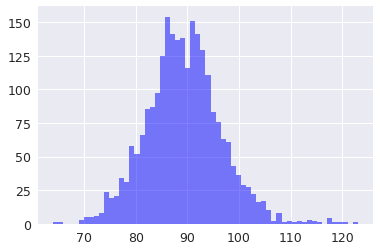

In [62]:
charter(game_18_df,'FGA',60)

In [63]:
team_df = advanced_18_df.copy()
oppt_df = advanced_18_df.copy()

In [64]:
def normalize_team_df(team_df):
    #normalize the team_df
    team_df['Win_ratio'] = team_df['W']/team_df['GP']
    team_df['AST%'] = team_df['AST%']/100
    team_df['OREB%'] = team_df['OREB%']/100
    team_df['DREB%'] = team_df['DREB%']/100
    team_df['REB%'] = team_df['REB%']/100
    team_df['TOV%'] = team_df['TOV%']/100
    team_df['eFG%'] = team_df['eFG%']/100
    team_df['TS%'] = team_df['TS%']/100

    # use minmax scaler to normalize rest of team_df
    team_df['OffRtg'] = (team_df['OffRtg']-team_df['OffRtg'].min())/(team_df['OffRtg'].max()-team_df['OffRtg'].min())
    team_df['DefRtg'] = (team_df['DefRtg']-team_df['DefRtg'].min())/(team_df['DefRtg'].max()-team_df['DefRtg'].min())
    team_df['NetRtg'] = (team_df['NetRtg']-team_df['NetRtg'].min())/(team_df['NetRtg'].max()-team_df['NetRtg'].min())
    team_df['AST/TO'] = (team_df['AST/TO']-team_df['AST/TO'].min())/(team_df['AST/TO'].max()-team_df['AST/TO'].min())
    team_df['AST Ratio'] = (team_df['AST Ratio']-team_df['AST Ratio'].min())/(team_df['AST Ratio'].max()-team_df['AST Ratio'].min())
    team_df['PACE'] = (team_df['PACE']-team_df['PACE'].min())/(team_df['PACE'].max()-team_df['PACE'].min())
    team_df['PIE'] = (team_df['PIE']-team_df['PIE'].min())/(team_df['PIE'].max()-team_df['PIE'].min())

    #drop usless column
    team_df.drop(['GP','W','L','MIN'],inplace=True,axis=1)
    
    names = list(team_df.columns)
    for i in range(1,len(names)):
        names[i] = 'team_' + names[i]
    team_df.columns = names
    
    return

def normalize_oppt_df(oppt_df):
    #feature engineering the same for oppt df
    #normalize the team_df
    oppt_df['Win_ratio'] = oppt_df['W']/oppt_df['GP']
    oppt_df['AST%'] = oppt_df['AST%']/100
    oppt_df['OREB%'] = oppt_df['OREB%']/100
    oppt_df['DREB%'] = oppt_df['DREB%']/100
    oppt_df['REB%'] = oppt_df['REB%']/100
    oppt_df['TOV%'] = oppt_df['TOV%']/100
    oppt_df['eFG%'] = oppt_df['eFG%']/100
    oppt_df['TS%'] = oppt_df['TS%']/100

    # use minmax scaler to normalize rest of team_df
    oppt_df['OffRtg'] = (oppt_df['OffRtg']-oppt_df['OffRtg'].min())/(oppt_df['OffRtg'].max()-oppt_df['OffRtg'].min())
    oppt_df['DefRtg'] = (oppt_df['DefRtg']-oppt_df['DefRtg'].min())/(oppt_df['DefRtg'].max()-oppt_df['DefRtg'].min())
    oppt_df['NetRtg'] = (oppt_df['NetRtg']-oppt_df['NetRtg'].min())/(oppt_df['NetRtg'].max()-oppt_df['NetRtg'].min())
    oppt_df['AST/TO'] = (oppt_df['AST/TO']-oppt_df['AST/TO'].min())/(oppt_df['AST/TO'].max()-oppt_df['AST/TO'].min())
    oppt_df['AST Ratio'] = (oppt_df['AST Ratio']-oppt_df['AST Ratio'].min())/(oppt_df['AST Ratio'].max()-oppt_df['AST Ratio'].min())
    oppt_df['PACE'] = (oppt_df['PACE']-oppt_df['PACE'].min())/(oppt_df['PACE'].max()-oppt_df['PACE'].min())
    oppt_df['PIE'] = (oppt_df['PIE']-oppt_df['PIE'].min())/(oppt_df['PIE'].max()-oppt_df['PIE'].min())

    #drop usless column
    oppt_df.drop(['GP','W','L','MIN'],inplace=True,axis=1)
    
    names = list(oppt_df.columns)
    for i in range(1,len(names)):
        names[i] = 'oppt_' + names[i]
    oppt_df.columns = names
    
    return

In [65]:
normalize_team_df(team_df)
normalize_oppt_df(oppt_df)

In [66]:
team_df.head()

,TEAM,team_OffRtg,team_DefRtg,team_NetRtg,team_AST%,team_AST/TO,team_AST Ratio,team_OREB%,team_DREB%,team_REB%,team_TOV%,team_eFG%,team_TS%,team_PACE,team_PIE,team_Win_ratio
0,Washington Wizards,0.563636,0.672269,0.392473,0.623,0.698413,0.636364,0.252,0.706,0.477,0.136,0.531,0.567,0.686910,0.435897,0.390244
1,Utah Jazz,0.572727,0.033613,0.806452,0.644,0.460317,0.654545,0.275,0.759,0.522,0.149,0.538,0.572,0.497976,0.880342,0.609756
2,Toronto Raptors,0.781818,0.159664,0.849462,0.603,0.603175,0.600000,0.265,0.726,0.502,0.138,0.543,0.579,0.454791,0.829060,0.707317
3,San Antonio Spurs,0.745455,0.470588,0.623656,0.580,0.952381,0.581818,0.246,0.744,0.501,0.122,0.534,0.572,0.234818,0.683761,0.585366
4,Sacramento Kings,0.509091,0.495798,0.473118,0.588,0.746032,0.509091,0.268,0.713,0.487,0.128,0.524,0.554,0.908232,0.504274,0.475610


In [67]:
oppt_df.head()

,TEAM,oppt_OffRtg,oppt_DefRtg,oppt_NetRtg,oppt_AST%,oppt_AST/TO,oppt_AST Ratio,oppt_OREB%,oppt_DREB%,oppt_REB%,oppt_TOV%,oppt_eFG%,oppt_TS%,oppt_PACE,oppt_PIE,oppt_Win_ratio
0,Washington Wizards,0.563636,0.672269,0.392473,0.623,0.698413,0.636364,0.252,0.706,0.477,0.136,0.531,0.567,0.686910,0.435897,0.390244
1,Utah Jazz,0.572727,0.033613,0.806452,0.644,0.460317,0.654545,0.275,0.759,0.522,0.149,0.538,0.572,0.497976,0.880342,0.609756
2,Toronto Raptors,0.781818,0.159664,0.849462,0.603,0.603175,0.600000,0.265,0.726,0.502,0.138,0.543,0.579,0.454791,0.829060,0.707317
3,San Antonio Spurs,0.745455,0.470588,0.623656,0.580,0.952381,0.581818,0.246,0.744,0.501,0.122,0.534,0.572,0.234818,0.683761,0.585366
4,Sacramento Kings,0.509091,0.495798,0.473118,0.588,0.746032,0.509091,0.268,0.713,0.487,0.128,0.524,0.554,0.908232,0.504274,0.475610


In [68]:
#game history data
game_df = game_18_df[['Team','Oppt','W/L']]
nba_abb_dict = dict(zip(teamAbbreviation_df.abbreviation,teamAbbreviation_df.team))
game_df['teamFull'] = game_df.Team.map(nba_abb_dict)
game_df['opptFull'] = game_df.Oppt.map(nba_abb_dict)
game_df = game_df.merge(team_df,how='left',left_on='teamFull',right_on='TEAM')
game_df = game_df.merge(oppt_df,how='left',left_on='opptFull',right_on='TEAM')

In [69]:
game_df.drop(['Team','Oppt','TEAM_x','TEAM_y'],axis=1,inplace=True)
game_df['W/L'] = game_df['W/L'].map({"W":1,"L":0})
game_df[game_df.isnull().any(axis=1)]

,W/L,teamFull,opptFull,team_OffRtg,team_DefRtg,team_NetRtg,team_AST%,team_AST/TO,team_AST Ratio,team_OREB%,...,oppt_AST Ratio,oppt_OREB%,oppt_DREB%,oppt_REB%,oppt_TOV%,oppt_eFG%,oppt_TS%,oppt_PACE,oppt_PIE,oppt_Win_ratio


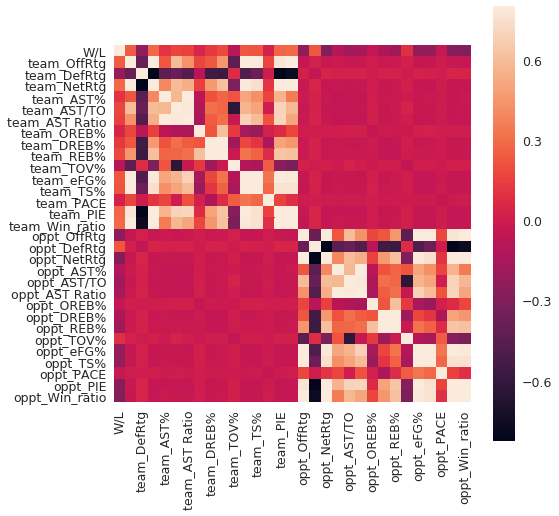

In [70]:
corrmat = game_df.corr()
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Index(['W/L', 'team_Win_ratio', 'team_NetRtg', 'team_PIE', 'team_OffRtg',
       'team_eFG%', 'oppt_DefRtg', 'team_TS%', 'team_REB%', 'team_AST/TO',
       'team_AST Ratio', 'team_DREB%'],
      dtype='object')


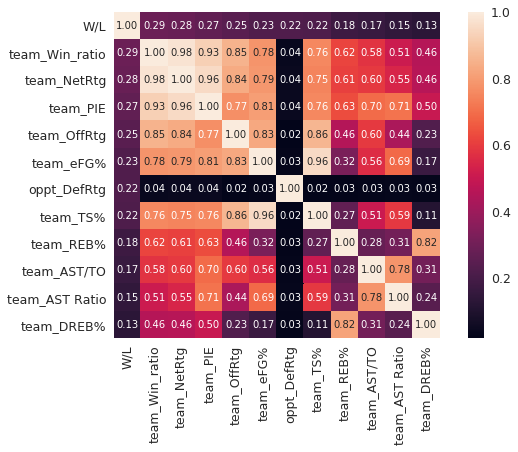

In [71]:
k = 12
cols = corrmat.nlargest(k, 'W/L')['W/L'].index
print(cols)
f, ax = plt.subplots(figsize=(10,6))
cm = np.corrcoef(game_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [72]:
#top 10 linear correlated with result. 
X = game_df[['team_Win_ratio', 'team_NetRtg', 'team_PIE', 'team_OffRtg',
       'team_eFG%', 'team_TS%', 'oppt_DefRtg', 'team_AST Ratio', 'team_AST/TO',
       'team_AST%', 'team_REB%']]
y = game_df[['W/L']]

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.2)

In [74]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1968, 11)
(492, 11)
(1968, 1)
(492, 1)


# modeling

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#knn 
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
print(metrics.accuracy_score(y_test, pred))
#print(knn.predict_proba(x_test))

0.6300813008130082


In [76]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(x_train,y_train)
pred = lg.predict(x_test)
print(metrics.accuracy_score(y_test, pred))

0.6443089430894309


In [77]:
#linear svm
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=2)
clf.fit(x_train, y_train)
print(clf.coef_)
print(clf.intercept_)
pred = (clf.predict(x_test))
#print(pred)
print(metrics.accuracy_score(y_test, pred))

[[ 1.80552551  0.25512081 -0.17585952  0.06037357 -0.45684086 -0.40021957
   0.85945622  0.05115561 -0.08340725  0.16605054 -0.37377114]]
[-0.76249054]
0.6402439024390244


In [78]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
print(metrics.accuracy_score(y_test, pred))

0.5813008130081301


In [79]:
# Gradient Treee Boosting
from sklearn.ensemble import GradientBoostingClassifier
clfgtb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=1, random_state=0).fit(x_train, y_train)
clfgtb.score(x_test, y_test)

0.6483739837398373

# predict 19-20 games

In [80]:
team = list(teamAbbreviation_df['team'])
comb = list(permutations(team,2))
game_19_df = pd.DataFrame(comb,columns=['Team','Oppt'])

In [81]:
team_19_df = advanced_19_df.copy()
oppt_19_df = advanced_19_df.copy()

In [82]:
normalize_team_df(team_19_df)
normalize_oppt_df(oppt_19_df)
oppt_19_df.head()

,TEAM,oppt_OffRtg,oppt_DefRtg,oppt_NetRtg,oppt_AST%,oppt_AST/TO,oppt_AST Ratio,oppt_OREB%,oppt_DREB%,oppt_REB%,oppt_TOV%,oppt_eFG%,oppt_TS%,oppt_PACE,oppt_PIE,oppt_Win_ratio
1,Milwaukee Bucks,0.692982,0.000000,1.000000,0.595,0.566667,0.756098,0.241,0.776,0.524,0.141,0.553,0.583,1.000000,1.000000,0.815385
2,Toronto Raptors,0.605263,0.246269,0.777202,0.626,0.600000,0.780488,0.259,0.715,0.494,0.142,0.536,0.574,0.507675,0.678261,0.718750
3,Los Angeles Lakers,0.719298,0.291045,0.813472,0.603,0.516667,0.804878,0.284,0.734,0.514,0.149,0.548,0.577,0.533991,0.834783,0.777778
4,Boston Celtics,0.692982,0.343284,0.761658,0.554,0.450000,0.390244,0.284,0.732,0.509,0.136,0.529,0.567,0.388158,0.678261,0.671875
5,Los Angeles Clippers,0.745614,0.373134,0.777202,0.573,0.350000,0.463415,0.284,0.734,0.515,0.144,0.532,0.574,0.674342,0.678261,0.687500


In [83]:
game_19_df = game_19_df.merge(team_19_df,how='left',left_on='Team',right_on='TEAM')
game_19_df = game_19_df.merge(oppt_19_df,how='left',left_on='Oppt',right_on='TEAM')

In [84]:
games_2019 = game_19_df[['team_Win_ratio', 'team_NetRtg', 'team_PIE', 'team_OffRtg',
       'team_eFG%', 'team_TS%', 'oppt_DefRtg', 'team_AST Ratio', 'team_AST/TO',
       'team_AST%', 'team_REB%']]

In [85]:
pred = clfgtb.predict(games_2019)
pred_prob = clfgtb.predict_proba(games_2019)

In [86]:
pred = np.where(pred == 0,'Loss','win')
#pred = np.where(pred == 0, pred, 'Win')
game_19_df['prediction'] = pred
predict_df = pd.DataFrame(pred_prob,columns=['team_loss_probability','oppt_loss_probability'])
game_19_df[['team_loss_probability','oppt_loss_probability']] = predict_df
game_19_df.head()

,Team,Oppt,TEAM_x,team_OffRtg,team_DefRtg,team_NetRtg,team_AST%,team_AST/TO,team_AST Ratio,team_OREB%,...,oppt_REB%,oppt_TOV%,oppt_eFG%,oppt_TS%,oppt_PACE,oppt_PIE,oppt_Win_ratio,prediction,team_loss_probability,oppt_loss_probability
0,Atlanta Hawks,Brooklyn Nets,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.514,0.151,0.515,0.550,0.577851,0.408696,0.468750,Loss,0.777141,0.222859
1,Atlanta Hawks,Boston Celtics,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.509,0.136,0.529,0.567,0.388158,0.678261,0.671875,Loss,0.812495,0.187505
2,Atlanta Hawks,Charlotte Hornets,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.486,0.150,0.504,0.539,0.000000,0.017391,0.353846,Loss,0.559518,0.440482
3,Atlanta Hawks,Chicago Bulls,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.481,0.153,0.515,0.547,0.462719,0.113043,0.338462,Loss,0.777141,0.222859
4,Atlanta Hawks,Cleveland Cavaliers,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.512,0.165,0.522,0.553,0.321272,0.000000,0.292308,Loss,0.506139,0.493861


In [87]:
game_19_df.head()

,Team,Oppt,TEAM_x,team_OffRtg,team_DefRtg,team_NetRtg,team_AST%,team_AST/TO,team_AST Ratio,team_OREB%,...,oppt_REB%,oppt_TOV%,oppt_eFG%,oppt_TS%,oppt_PACE,oppt_PIE,oppt_Win_ratio,prediction,team_loss_probability,oppt_loss_probability
0,Atlanta Hawks,Brooklyn Nets,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.514,0.151,0.515,0.550,0.577851,0.408696,0.468750,Loss,0.777141,0.222859
1,Atlanta Hawks,Boston Celtics,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.509,0.136,0.529,0.567,0.388158,0.678261,0.671875,Loss,0.812495,0.187505
2,Atlanta Hawks,Charlotte Hornets,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.486,0.150,0.504,0.539,0.000000,0.017391,0.353846,Loss,0.559518,0.440482
3,Atlanta Hawks,Chicago Bulls,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.481,0.153,0.515,0.547,0.462719,0.113043,0.338462,Loss,0.777141,0.222859
4,Atlanta Hawks,Cleveland Cavaliers,Atlanta Hawks,0.22807,0.955224,0.062176,0.589,0.133333,0.463415,0.267,...,0.512,0.165,0.522,0.553,0.321272,0.000000,0.292308,Loss,0.506139,0.493861


In [88]:
#convert to result csv
game_19_df.to_csv(r'nba_prediction.csv')

In [89]:
data_bucket = 'nba-public-data'
model_bucket = 'nba-model'
s3 = boto3.resource('s3')
# modelbucketref = s3.Bucket(model_bucket)

# modelbucketref.upload_file('/nba_prediction.csv', model_bucket, 'nba_prediction.csv')
s3 = boto3.resource('s3')
s3.meta.client.upload_file('nba_prediction.csv', model_bucket, 'nba_prediction.csv')
#modelbucketref.Object(model_bucket,'nba_prediction').upload_file('/tmp/nba_prediction.csv')
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')